<a href="https://colab.research.google.com/github/LSSTDESC/MALTS/blob/main/HackDay_Feb2023/sprintWeek_lightcurve_cpu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Hack on ELAsTiCC Light Curve Physics
_Alex Gagliano and Benjamin Remy_
#### This jupyter notebook provides a simple example of how physical parameters (the mass of radioactive nickel produced, the time of explosion, and the ejecta timescale of radiative diffusion) are extracted from supernova photometry.
We'll use a supernova from the Extended LSST Astronomical Time-Series Classification Challenge (ELAsTiCC) for our analysis.

In [ ]:
!git clone https://github.com/LSSTDESC/MALTS.git

fatal: destination path 'MALTS' already exists and is not an empty directory.


In [ ]:
!pip install --quiet emcee corner numpyro

In [ ]:
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd 
import seaborn as sns
from scipy import special
import emcee
from scipy.optimize import minimize
import time
import corner

First, we add some code to style our plots:

In [ ]:
def stylePlots():
    """A quick function to make subsequent plots look nice (requires seaborn).
    """
    sns.set_context("talk",font_scale=1.25)

    sns.set_style('white', {'axes.linewidth': 0.5})
    plt.rcParams['xtick.major.size'] = 15
    plt.rcParams['ytick.major.size'] = 15

    plt.rcParams['xtick.minor.size'] = 10
    plt.rcParams['ytick.minor.size'] = 10
    plt.rcParams['xtick.minor.width'] = 2
    plt.rcParams['ytick.minor.width'] = 2

    plt.rcParams['xtick.major.width'] = 2
    plt.rcParams['ytick.major.width'] = 2
    plt.rcParams['xtick.bottom'] = True
    plt.rcParams['xtick.top'] = True
    plt.rcParams['ytick.left'] = True
    plt.rcParams['ytick.right'] = True

    plt.rcParams['xtick.minor.visible'] = True
    plt.rcParams['ytick.minor.visible'] = True
    plt.rcParams['xtick.direction'] = 'in'
    plt.rcParams['ytick.direction'] = 'in'

    plt.rcParams.update({
        #"text.usetex": True,turn off for now, not sure where my latex went
        "text.usetex": False,
        "font.family": "serif",
        "font.serif": ["Palatino"],
    })
    
stylePlots()

Next, we read in a data file that contains photometry and host-galaxy properties for 5,000 SNe Ia in the training set for the ELAsTiCC challenge. 

In [ ]:
df = pd.read_json("MALTS/HackDay_Feb2023/ELAsTiCC_SNe_5k.json")

Let's plot the data for one supernova:

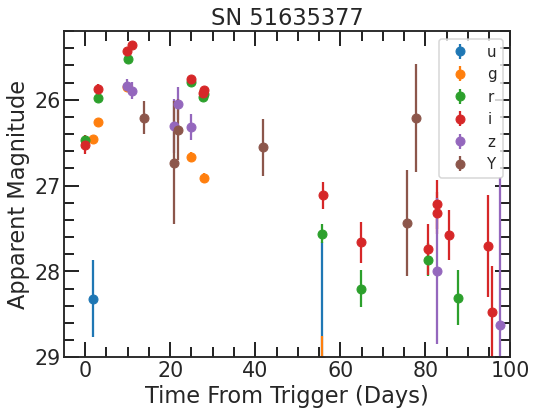

In [ ]:
#Plot one supernova across all bands 
zp = 31.5

chosen_idx = 15

t0 = df['MJD_TRIGGER'].values[chosen_idx]
t = np.array(df['MJD'].values[chosen_idx]) - t0
mag = np.array(df['MAG'].values[chosen_idx])
magerr = np.array(df['MAGERR'].values[chosen_idx])

#floor the values that are missing
magerr[magerr == None] = 1.0
mag[mag == None] = zp

bands = np.array(df['Filter'].values[chosen_idx])
photo_z = df['HOSTGAL_PHOTOZ'].values[chosen_idx]
mwebv = df['MWEBV'].values[chosen_idx]
name = df['SNID'].values[chosen_idx]

band_list = 'ugrizY'

plt.figure(figsize=(8,6))
for band in band_list:
    idx = band == bands 
    plt.errorbar(t[idx], mag[idx], fmt='o', yerr=magerr[idx], label=band)

plt.ylim((29, 25.2))
plt.xlim(-5, 100)

plt.xlabel("Time From Trigger (Days)")
plt.ylabel("Apparent Magnitude")
plt.title("SN %s"%name)

plt.legend(fontsize=15);

In order to understand how the supernova physics evolves in time, we first have to create an underlying representation of its observed behavior. We do this by building a gaussian process model, and interpolating the photometry in each passband onto the same uniformly-sampled grid in time:

In [ ]:
interpolated_DF = pd.read_csv("MALTS/HackDay_Feb2023/SN51635377_ugrizY.txt", sep=' ')

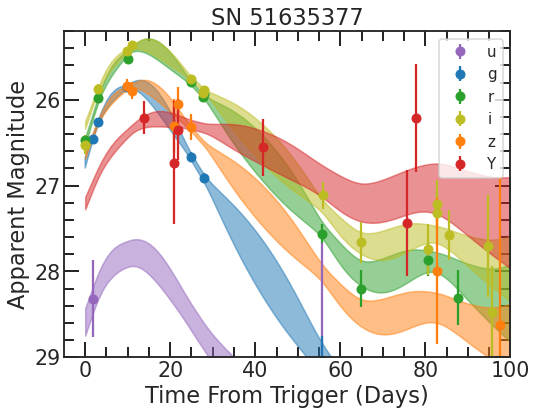

In [ ]:
#interpolated light curves 
colset = sns.color_palette()
cols_bands = [colset[4], colset[0], colset[2], colset[8], colset[1], colset[3]]
    
plt.figure(figsize=(8,6))
for i in np.arange(len(band_list)):
    band = band_list[i]
    idx = band == bands 
    plt.fill_between(interpolated_DF['t'], interpolated_DF['%s'%band]-interpolated_DF['%s_err'%band], interpolated_DF['%s'%band]+interpolated_DF['%s_err'%band],  color=cols_bands[i], alpha=0.5)
    plt.errorbar(t[idx], mag[idx], fmt='o', yerr=magerr[idx], label=band, color=cols_bands[i])
    
plt.ylim((29, 25.2))
plt.xlim(-5, 100)

plt.xlabel("Time From Trigger (Days)")
plt.ylabel("Apparent Magnitude")
plt.title("SN %s"%name)

plt.legend(fontsize=15);

Not a terrible model, although you can tell our data for Y-band is noisy and our data for u-band quickly gets very faint. We might not want to trust this model after ~30 days or so. For now, I've taken the photometry at each phase and fit them to a blackbody curve (after k-correcting and accounting for simulated extinction and time dilation). I can integrate this blackbody curve to estimate the bolometric luminosity as a function of time. This looks like the following:

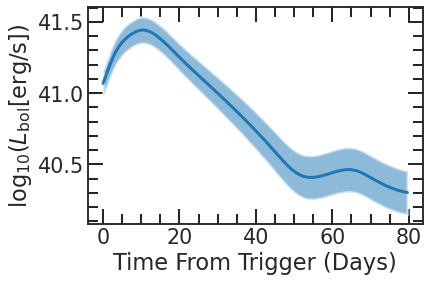

In [ ]:
df_interp = pd.read_csv("MALTS/HackDay_Feb2023/logL-bb_SN51635377_ugrizY.txt", sep='\t', header=None, names=['phase', 'logL', 'logLerr'])
plt.plot(df_interp['phase'], df_interp['logL'], '-', lw=3)
plt.fill_between(df_interp['phase'], df_interp['logL']-df_interp['logLerr'], df_interp['logL']+df_interp['logLerr'], lw=3,alpha=0.5)


plt.xlabel("Time From Trigger (Days)")
plt.ylabel(r"log$_{10}(L_{\rm bol} \left[\rm{erg/s}\right])$");

Now we fit this light curve to a physical model. We use the treatment from Arnett et al. (1982), which assumes that the emission from the supernova is caused by the radioactive decay of $^{56}$Ni into $^{56}$Co, and then $^{56}$Co into $^{56}$Fe. Note that this assumes that the observed luminosity is equal to the rate of radioactive heating at peak! This is not necessarily the case (particularly for dense heating sources as with the explosion of a small white dwarf), but as a first pass the model works well. We set up the relevant equations:

In [ ]:
def erfi(x):
    return np.real(-1j*special.erf(1j*x))

In [ ]:
#some constants
tauNi = 8.77 #decay timescale of nickel, in days
tauCo = 111.3 #decay timescale of cobalt, in days

#energy injection through Nickel and Cobalt decay
epsNi = 3.9E10
epsCo = 6.78E9

#Mass of the sun in grams
MSun = 2E33

#def variables/functions
#tau is the diffusion timescale and MNi is the total mass of nickel
def term1(tau):
    return tau/(2*tauNi)

def term2(tau):
    return tau * (tauCo - tauNi) / (2 * tauNi * tauCo)

def A(t, tau):
    return np.exp(-(term1(tau)**2)) * (np.sqrt(np.pi) * term1(tau) * erfi(t/tau - term1(tau)) + np.sqrt(np.pi) * term1(tau) * erfi(term1(tau)) + np.exp((t/tau - term1(tau))**2) - np.exp(term1(tau)**2))

def B(t, tau):
    return np.exp(-(term2(tau) - term1(tau))**2) * (np.sqrt(np.pi) * (term2(tau) - term1(tau)) * (erfi(term2(tau) - term1(tau)) - erfi(term2(tau) + t/tau - term1(tau))) + np.exp((term2(tau) + t/tau - term1(tau))**2) - np.exp((term2(tau) - term1(tau))**2))

def L(t, tau, MNi):
    return ((MNi*MSun) * np.exp(-(t/tau)**2) * ((epsNi - epsCo) * A(t, tau) +  B(t, tau)))

In [ ]:
t = df_interp['phase'].values
y = 10**df_interp['logL'].values
yerr = 2.303 * df_interp['logLerr'].values * y #error propagation!

dt = 0.0 #days
tdiff = 10. #days
MNi = 0.05 #Msol
print(t)
print(L(t+dt, tdiff, MNi))
print(L(t+dt, tdiff, MNi).dtype)

[ 0.     0.805  1.609  2.414  3.218  4.023  4.827  5.632  6.436  7.241
  8.045  8.85   9.654 10.459 11.263 12.068 12.873 13.677 14.482 15.286
 16.091 16.895 17.7   18.504 19.309 20.113 20.918 21.722 22.527 23.332
 24.136 24.941 25.745 26.55  27.354 28.159 28.963 29.768 30.572 31.377
 32.181 32.986 33.79  34.595 35.4   36.204 37.009 37.813 38.618 39.422
 40.227 41.031 41.836 42.64  43.445 44.249 45.054 45.859 46.663 47.468
 48.272 49.077 49.881 50.686 51.49  52.295 53.099 53.904 54.708 55.513
 56.317 57.122 57.927 58.731 59.536 60.34  61.145 61.949 62.754 63.558
 64.363 65.167 65.972 66.776 67.581 68.386 69.19  69.995 70.799 71.604
 72.408 73.213 74.017 74.822 75.626 76.431 77.235 78.04  78.844 79.649]
[0.00000000e+00 1.95803151e+40 7.29088074e+40 1.51973770e+41
 2.48486911e+41 3.54935552e+41 4.63956442e+41 5.69596749e+41
 6.66447315e+41 7.50772821e+41 8.19606071e+41 8.71533487e+41
 9.05920970e+41 9.23280069e+41 9.24744509e+41 9.12054920e+41
 8.87302876e+41 8.52822565e+41 8.10837643e+41

Next, we define the equations we'll need for a markov chain exploration of our parameter space. We'll start off with an initial guess that the supernova exploded when the first non-zero photometric measurement was taken ($dt = 0$). We also define the diffusion timescale and the mass (in solar masses) of radioactive Nickel created in the explosion. We'll set broad and flat priors for these parameters. 

One more thing is that we'll only look at fitting the photometry in the first 30 days. This is both because the assumption of constant opacity starts to break down around here, and also because we could see from our gaussian process model that we might not trust the u-band model beyond 30 days. 

In [ ]:
def log_likelihood(theta, tobs, yobs, yerr):
    log_like_sum = 0
    dt, tdiff, MNi = theta
    return -0.5 * np.sum((yobs - L(tobs+dt, tdiff, MNi)) ** 2 / yerr**2)

def log_prior(theta):
    dt, tdiff, MNi = theta
    if 0 < dt < 10 and 7 < tdiff < 25 and 1.e-2 < MNi < 1.e-1:
        return 0.0
    return -np.inf

def log_probability(theta, t, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, t, y, yerr)

dt = 0.0 #days
tdiff = 10. #days
MNi = 0.05 #Msol
theta = [dt, tdiff, MNi]

#take the first interpolated observation
t = df_interp['phase'].values
y = 10**df_interp['logL'].values
yerr = 2.303 * df_interp['logLerr'].values * y #error propagation!

#trim before opacity effects become important!
y = y[t < 30]
yerr = yerr[t < 30]
t = t[t < 30]

nll = lambda *args: -log_likelihood(*args)
soln = minimize(nll, theta, args=(t, y, yerr), bounds=[(0, 10), (7, 25), (1.e-2, 1.e-1)])

pos = soln.x + soln.x* 1.e-1*np.random.randn(64, 3)

nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(t, y, yerr)
)
start = time.time()
sampler.run_mcmc(pos, 10000, progress=True);
end = time.time()
time_spanned = end - start

  0%|          | 0/10000 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 10000/10000 [01:50<00:00, 90.83it/s]


Looking at the chains:

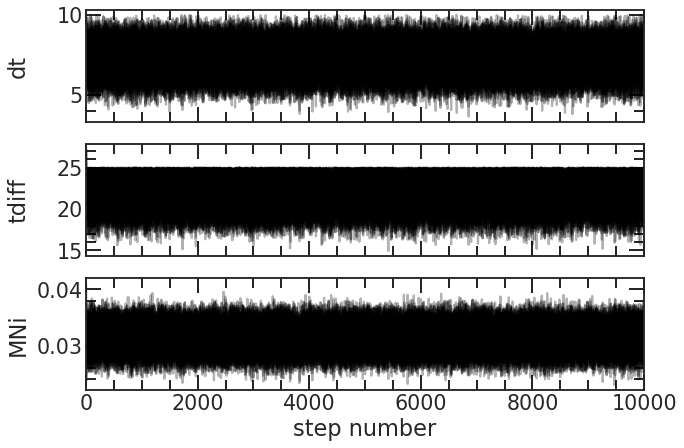

In [ ]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["dt", "tdiff", "MNi"]
for i in range(3):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

And now making a corner plot of our results: 

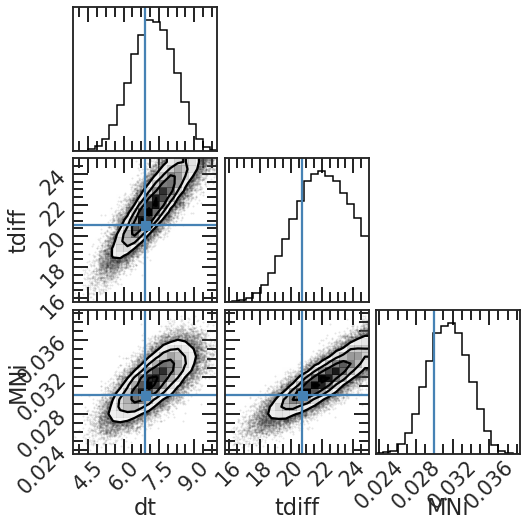

In [ ]:
flat_samples = sampler.get_chain(discard=300, thin=15, flat=True)

fig = corner.corner(
    flat_samples, labels=labels, truths=[6.9, 20.7, 0.03]
);

Here our "truth" values were determined by a grid serach of the parameter space. The parameters all look a little over-estimated here, but as we'll see below, the uncertainties are pretty high for our interpolated luminosity. Taking the best-fit values: 

In [ ]:
dt = np.percentile(flat_samples[:, 0], [50])[0]
tdiff =  np.percentile(flat_samples[:, 1], [50])[0]
MNi =  np.percentile(flat_samples[:, 2], [50])[0]

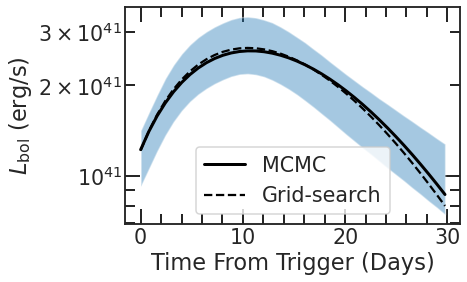

In [ ]:
plt.plot(t, L(t+dt, tdiff, MNi), zorder=100, lw=3, c='k', label='MCMC')
plt.plot(t, L(t+6.9, 20.7, 0.03), zorder=100, ls='--', c='k', label='Grid-search')
plt.fill_between(t, y-yerr, y+yerr, alpha=0.4)
plt.xlabel("Time From Trigger (Days)")
plt.ylabel(r"$L_{\rm bol}$ (erg/s)")
plt.yscale("log");
plt.legend();

In [ ]:
print("Amount of time elapsed by the MCMC: %.2f sec."% time_spanned)

Amount of time elapsed by the MCMC: 110.12 sec.


Both answers are well within the uncertainties! Now, can we speed this up with jax and/or flowMC?

In [ ]:
import jax
import jax.numpy as jnp
from tensorflow_probability.substrates import jax as tfp

## run jax implementation

Let's rewrite `speciel.erfi` from `dawsn`

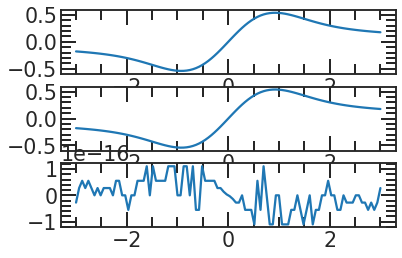

In [ ]:
x = np.linspace(-3, 3, 100)
plt.subplot(311)
plt.plot(x,special.erfi(x)*np.exp(-x**2)*np.sqrt(np.pi)/2)
plt.subplot(312)
plt.plot(x,special.dawsn(x))
plt.subplot(313)
plt.plot(x,(special.erfi(x)*np.exp(-x**2)*np.sqrt(np.pi)/2)-special.dawsn(x))

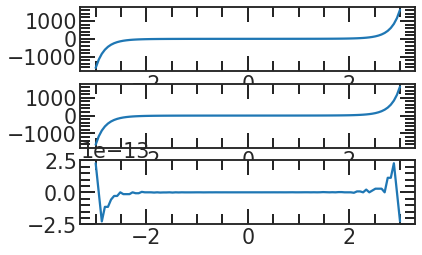

In [ ]:
plt.subplot(311)
#plt.plot(x,special.erfi(x))
plt.plot(x,special.erfi(x))
plt.subplot(312)
plt.plot(x,special.dawsn(x)/np.exp(-x**2)/np.sqrt(np.pi)*2)
plt.subplot(313)
plt.plot(x,special.dawsn(x)/np.exp(-x**2)/np.sqrt(np.pi)*2-special.erfi(x))

To make it compatible to JAX float32 we needed to:
- factorize high order of magnitude numbers like `1E33`
- rewrite `scipy.special.erfi` from jax compatible functions
- use `jax.lax.cond` for the conditional log prior

In [ ]:
def erfi(x):
    return tfp.math.dawsn(x)/jnp.exp(-x**2)/jnp.sqrt(np.pi)*2

In [ ]:
dt = 0.0 #days
tdiff = 10. #days
MNi = 0.05 #Msol
theta = [dt, tdiff, MNi]

#take the first interpolated observation
t = df_interp['phase'].values
y = 10**df_interp['logL'].values / 1e33 /1e9
yerr = 2.303 * df_interp['logLerr'].values * y #error propagation!

#trim before opacity effects become important!
y = y[t < 30]
yerr = yerr[t < 30]
t = t[t < 30]

#some constants
tauNi = jnp.array(8.77)#decay timescale of nickel, in days
tauCo = jnp.array(111.3) #decay timescale of cobalt, in days

#energy injection through Nickel and Cobalt decay
epsNi = jnp.array(3.9E1)
epsCo = jnp.array(6.78)

MSun = jnp.array(2.)#E33

#def variables/functions
#tau is the diffusion timescale and MNi is the total mass of nickel
def term1(tau):
    return tau/(2*tauNi)

def term2(tau):
    return tau * (tauCo - tauNi) / (2 * tauNi * tauCo)

def B(t, tau):
    return jnp.exp(-(term2(tau) - term1(tau))**2) * (jnp.sqrt(np.pi) * (term2(tau) - term1(tau)) * (erfi(term2(tau) - term1(tau)) - erfi(term2(tau) + t/tau - term1(tau))) + jnp.exp((term2(tau) + t/tau - term1(tau))**2) - jnp.exp((term2(tau) - term1(tau))**2))

def A(t, tau):
    return jnp.exp(-(term1(tau)**2)) * (jnp.sqrt(np.pi) * term1(tau) * erfi(t/tau - term1(tau)) + jnp.sqrt(np.pi) * term1(tau) * erfi(term1(tau)) + jnp.exp((t/tau - term1(tau))**2) - jnp.exp(term1(tau)**2))

def L(t, tau, MNi):
    return ((MNi*MSun) * jnp.exp(-(t/tau)**2) * ((epsNi - epsCo) * A(t, tau) +  B(t, tau)/1e9))

def log_likelihood(theta, tobs, yobs, yerr):
    log_like_sum = 0
    dt, tdiff, MNi = theta
    return -0.5 * jnp.sum((yobs - L(tobs+dt, tdiff, MNi)) ** 2 / yerr**2)

print(log_likelihood(theta, t, y, yerr))

def log_prior(theta):
    dt, tdiff, MNi = theta
    return jax.lax.cond((0<dt)&(dt<10)&(7<tdiff)&(tdiff<25)&(1.e-2<MNi)&(MNi<1.e-1), lambda: 0., lambda: -jnp.inf)

print(log_prior(theta))

@jax.jit
def log_probability(theta, t, y, yerr):
    lp = log_prior(theta)

    def true_fn(theta, t, y, yerr):
        return -jnp.inf
    
    def false_fn(theta, t, y, yerr):
        return log_likelihood(theta, t, y, yerr)

    ll = jax.lax.cond(jnp.isfinite(log_prior(theta)), false_fn, true_fn, theta, t, y, yerr)
    return lp + ll

print(log_probability(theta, t, y, yerr))

-1008.8519
-inf
-inf


In [ ]:
tfd = tfp.distributions

num_chains = 64
key = jax.random.PRNGKey(0)
key, subkey = jax.random.split(key, num=2)
init_dt = tfd.Uniform(0., 10.).sample(sample_shape=(num_chains,), seed=subkey)
key, subkey = jax.random.split(key, num=2)
init_tdiff = tfd.Uniform(7., 25.).sample(sample_shape=(num_chains,), seed=subkey)
key, subkey = jax.random.split(key, num=2)
init_MNi = tfd.Uniform(1.e-2, 1.e-1).sample(sample_shape=(num_chains,), seed=subkey)

init = jnp.stack([init_dt, init_tdiff, init_MNi], axis=1)
init.shape

(64, 3)

In [ ]:
nwalkers, ndim = init.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(t, y, yerr)
)
start = time.time()
sampler.run_mcmc(init, 10000, progress=True)#, skip_initial_state_check=True);
end = time.time()
time_spanned = end - start

100%|██████████| 10000/10000 [00:28<00:00, 349.60it/s]


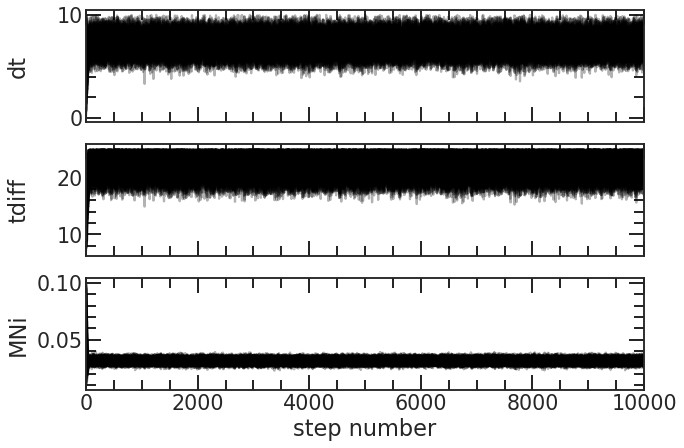

In [ ]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["dt", "tdiff", "MNi"]
for i in range(3):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

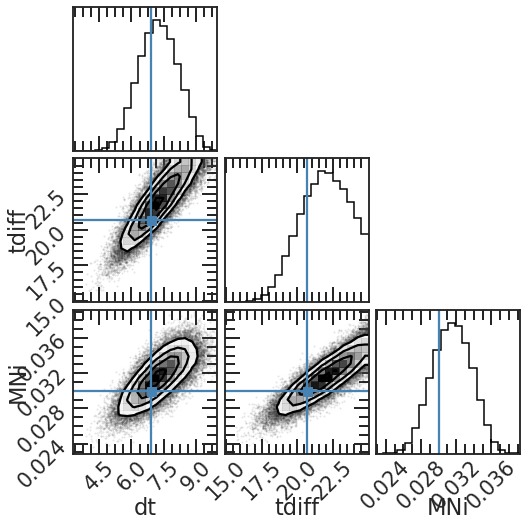

In [ ]:
flat_samples = sampler.get_chain(discard=300, thin=15, flat=True)

fig = corner.corner(
    flat_samples, labels=labels, truths=[6.9, 20.7, 0.03]
);

By jitting `log_probability` the inference goes form `01:46` to `00:42` on cpu, using the same `emcee` sampler

Let's use a JAX sampler now:

---



In [ ]:
# Simple normalization trick to use the same step size for every parameter

@jax.jit
def log_likelihood(theta, tobs, yobs, yerr):
    log_like_sum = 0
    dt, tdiff, MNi = theta
    MNi /= 100
    return -0.5 * jnp.sum((yobs - L(tobs+dt, tdiff, MNi)) ** 2 / yerr**2)
print(log_likelihood(theta, t, y, yerr))

@jax.jit
def log_prior(theta):
    dt, tdiff, MNi = theta
    MNi /= 100  
    return jax.lax.cond((0<dt)&(dt<10)&(7<tdiff)&(tdiff<25)&(1.e-2<MNi)&(MNi<1.e-1), lambda: 0., lambda: -jnp.inf)

print(log_prior(theta))

@jax.jit
def log_probability(theta, t, y, yerr):
    lp = log_prior(theta)
    def true_fn(theta, t, y, yerr):
        return -jnp.inf
    def false_fn(theta, t, y, yerr):
        return log_likelihood(theta, t, y, yerr)
    ll = jax.lax.cond(jnp.isfinite(log_prior(theta)), false_fn, true_fn, theta, t, y, yerr)
    return lp + ll

-363.25885
-inf


In [ ]:
tfd = tfp.distributions

num_chains = 64
key = jax.random.PRNGKey(0)
key, subkey = jax.random.split(key, num=2)
init_dt = tfd.Uniform(0., 10.).sample(sample_shape=(num_chains,), seed=subkey)
key, subkey = jax.random.split(key, num=2)
init_tdiff = tfd.Uniform(7., 25.).sample(sample_shape=(num_chains,), seed=subkey)
key, subkey = jax.random.split(key, num=2)
init_MNi = tfd.Uniform(1.e-2, 1.e-1).sample(sample_shape=(num_chains,), seed=subkey) * 100

init = jnp.stack([init_dt, init_tdiff, init_MNi], axis=1)
init.shape

(64, 3)

In [ ]:
from functools import partial

In [ ]:
# runing one chain

In [ ]:
num_results = int(10e2)
num_burnin_steps = int(1)

adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(
    tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=partial(log_probability, t=t, y=y, yerr=yerr),
        num_leapfrog_steps=3,
        step_size=1e-2),
    num_adaptation_steps=int(num_burnin_steps * 0.8))

key, subkey = jax.random.split(key, num=2)
@partial(jax.jit, static_argnums=(0,1))
def run_chain(num_burnin_steps, num_results):
  # Run the chain (with burn-in).
  samples, is_accepted = tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      current_state=init[0],
      kernel=adaptive_hmc,
      trace_fn=lambda _, pkr: pkr.inner_results.is_accepted,
      seed = subkey,
      )
  
  return samples, is_accepted

In [ ]:
%%time
samples, is_accepted = run_chain(1, 10)

CPU times: user 5.19 s, sys: 40.8 ms, total: 5.23 s
Wall time: 5.22 s


In [ ]:
%%time
samples, is_accepted = run_chain(1, 10)

CPU times: user 952 µs, sys: 0 ns, total: 952 µs
Wall time: 646 µs


In [ ]:
%%time
samples, is_accepted = run_chain(1, 10000*num_chains)

CPU times: user 8.2 s, sys: 32.4 ms, total: 8.24 s
Wall time: 8.13 s


In [ ]:
samples = jnp.concatenate([samples[:,:2], samples[:,-1:]/100], axis=-1)

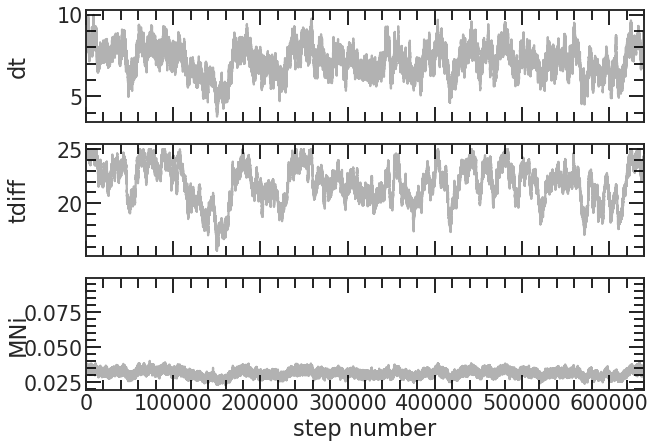

In [ ]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
labels = ["dt", "tdiff", "MNi"]
for i in range(3):
    ax = axes[i]
    ax.plot(samples[:, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

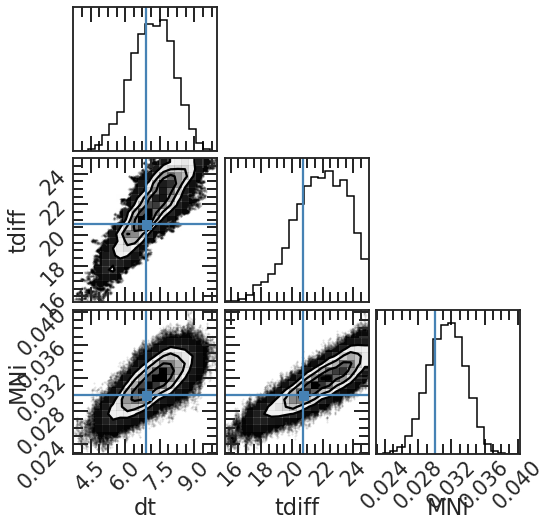

In [ ]:
#flat_samples = sampler.get_chain(discard=300, thin=15, flat=True)

fig = corner.corner(
    np.array(samples[5000:]), labels=labels, truths=[6.9, 20.7, 0.03]
);

12.222222222222221